# 1 downloading data: 

either from datareader or yfinance 

In [3]:
import pandas as pd 
import yfinance as yf
import yahoofinancials 

# download data 

In [4]:
df_on = yf.download('ON', 
                   start ='2011-01-01', 
                   end = '2020-03-16', 
                   progress= False)

# 2) gettting data from quandl

API KEY = RRKsPfQSbcxMaufRA95

In [5]:
import quandl

In [6]:
QUANDL_KEY = 'RRKsPfQSbcxMaufRA95r'
quandl.ApiConfig.api_key = QUANDL_KEY

In [7]:
df_quandl= quandl.get(dataset='WIKI/AAPL',
                       start_date='2000-01-01', 
                       end_date='2010-12-31')
 

# 3) GETTING DATA FROM INTRINIO

In [8]:
import intrinio_sdk

In [9]:
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OjEyMDRhYTY5MGNiZWRjMWJiNTEyMmM2MTU3MWMyZjE0' 
security_api = intrinio_sdk.SecurityApi()



In [10]:
r = security_api.get_security_stock_prices(identifier='AAPL', 
                                           start_date='2000-01-01',
                                           end_date='2010-12-31',frequency = 'daily',
                                          page_size = 10000)

In [11]:
responses = [x.to_dict() for x in r.stock_prices]
df_intrinio = pd.DataFrame(responses).sort_values('date')
df_intrinio.set_index('date', inplace=True)


# Converting price to returns 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df_on.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [14]:
df_on['log_returns'] = np.log(df_on.adj_close/ df_on.adj_close.shift(1))

In [21]:
df_cpi = quandl.get(dataset= "RATEINF/CPI_USA", 
                   start_date = df_on.index[0], 
                   end_date = df_on.index[-1])

In [22]:
df_on = df_on.asfreq('1M', 'ffill' )

In [24]:
df_on['inflation_rate'] = df_on.Value.pct_change()

In [25]:

df_on.insert(6,column='simple_rtrn', value = df_on.adj_close.pct_change())

In [26]:
df_on['real_rtn'] = (df_on.simple_rtrn + 1) / (df_on.inflation_rate + 1) - 1

In [27]:
df_on = df_on.iloc[:,4:]

# calculating realized volatility

In [29]:
df_on_log = df_on.iloc[:,[-1]] 

In [30]:
def rv(x): 
    return np.sqrt(np.sum(x**2))

In [31]:
df_rv = df_on_log.resample('M').agg(rv) 

In [32]:
df_rv.rename(columns={'log_returns':"rv"}, inplace = True)

In [33]:
df_rv.rv = df_rv.rv * np.sqrt(12)

AttributeError: 'DataFrame' object has no attribute 'rv'

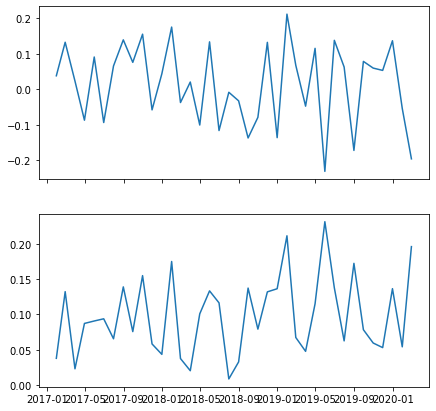

In [34]:
f,a = plt.subplots(2,1,figsize= (7,7), sharex = True)
a[0].plot(df_on_log.loc['2017':,:])
a[1].plot(df_rv.loc['2017':,:])

In [35]:
df_rv['change_rate'] = df_rv.rv.pct_change()

AttributeError: 'DataFrame' object has no attribute 'rv'

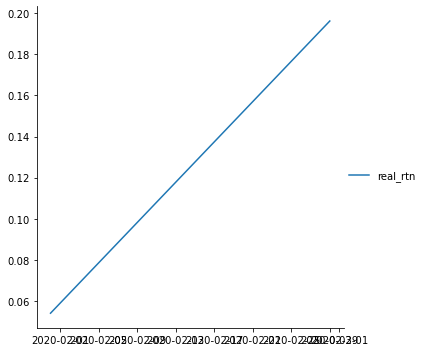

In [36]:
sns.relplot(data = df_rv['2020':], kind = 'line')

In [37]:
df_on.resample('Y').min()

,adj_close,Volume,simple_rtrn,log_returns,Value,inflation_rate,real_rtn
Date,,,,,,,
2011-12-31,7.18,2597800,-0.170010,-0.032491,220.223,-0.002467,-0.170744
2012-12-31,6.15,3145100,-0.184019,-0.019447,226.665,-0.004738,-0.183061
2013-12-31,7.06,1043800,-0.121359,-0.009622,230.280,-0.002575,-0.122415
2014-12-31,8.29,1309700,-0.084016,-0.035169,233.916,-0.005670,-0.084705
2015-12-31,9.40,2390000,-0.118401,-0.032925,233.707,-0.004706,-0.121479
2016-12-31,8.39,2207400,-0.126531,-0.029138,236.916,-0.001622,-0.127972
2017-12-31,13.32,3029700,-0.093023,-0.033290,242.839,-0.000690,-0.093845
2018-12-31,16.51,2985400,-0.139208,-0.039952,247.867,-0.003349,-0.137366
2019-12-31,17.76,1224100,-0.229835,-0.032025,251.712,-0.000910,-0.231471


# initial DF transforms 

In [453]:
def pct_remove(x): 
    x = str(x)
    return re.sub(r"%\Z","", x) 
   

In [455]:
df_value[['pct_change','yield']] = df_value.transform({'pct_change': lambda x: pct_remove(x), 'yield': lambda x: pct_remove(x)})

In [456]:
df_value[['price','52_high','52_low']] = df_value[['price','52_high','52_low']].applymap(lambda x: str(x).replace("$", "")) \
                                                                            .applymap(lambda x: x.replace(",", ""))
                                      


In [457]:
df_value[['pct_change',"52_high", "52_low"]] = df_value[['pct_change',"52_high", "52_low"]].applymap(lambda x: float(x))

In [461]:
df_value['price'] = df_value['price'].map(lambda x: float(x))

In [462]:
df_value['rtrn_high'] = (2000 /df_value['price'] ) * df_value['52_high']
df_value['rtrn_mid'] = (2000 /df_value['price'] ) * (df_value['52_high'] + df_value['52_low'])/2

In [477]:
df_value['pct_change'] = df_value['pct_change'].map(lambda x: np.abs(x))

In [478]:
df_value.sort_values(['rtrn_high','rtrn_mid','pct_change'], ascending= False, inplace=True)


In [482]:
df_value_top = df_value[df_value['rtrn_high'] >= 20000]

In [514]:
df_value_top = df_value_top.drop(index = 100)

In [515]:
df_value_top.sort_values('pct_change', ascending= False)

,Company Name,Ticker,price,52_high,52_low,pct_change,yield,Industry,rtrn_high,rtrn_mid
0,PlayAGS Inc,AGS,0.78,26.80,1.72,56.34,--,Entertainment Tech,68717.948718,36564.102564
2,Ruths Hospitality Group Inc,RUTH,2.51,27.14,5.28,53.69,11.07,Restaurant,21625.498008,12916.334661
11,Noble Midstream Partners LP,NBLX,2.43,40.30,3.96,40.88,66.94,Pipeline MLPs,33168.724280,18213.991770
13,Fluidigm Corporation,FLDM,1.35,14.90,2.12,40.79,--,Med Supp Non-Invasive,22074.074074,12607.407407
23,Party City Holdco,PRTY,0.30,8.73,0.43,38.19,--,Retail (Hardlines),58200.000000,30533.333333
26,NGL Energy Partner LP,NGL,1.35,15.71,2.02,37.41,72.22,Pipeline MLPs,23274.074074,13133.333333
42,Key Energy Services Inc,KEGXD,1.55,310.00,1.55,33.76,--,Oilfield Svcs/Equip.,400000.000000,201000.000000
43,Summit Midstream Partners LP,SMLP,0.54,10.05,0.70,33.74,61.73,Pipeline MLPs,37222.222222,19907.407407
74,Capital Senior Living Corp,CSU,0.50,5.64,0.61,28.64,--,Medical Services,22560.000000,12500.000000
98,Kosmos Energy Ltd,KOS,0.51,7.55,0.65,26.49,26.05,Petroleum (Producing),29607.843137,16078.431373


In [614]:
df_value_grouped = df_value_top.groupby(['Industry','Ticker']).agg(max)

In [550]:
df_value_grouped.sort_values('pct_change', ascending= False, inplace= True)

In [560]:
df_value_grouped = df_value_grouped.drop(index = 'Metals & Mining (Div.)')

In [865]:
df_value[df_value['Ticker'] == 'WHD']

,Company Name,Ticker,price,52_high,52_low,pct_change,yield,Industry,rtrn_high,rtrn_mid


# getting top initial DF 

In [615]:
df_value_final = df_value.groupby(['Industry','Ticker']).agg(max)

In [1]:

low_tick = ['GTX','XSPA', 'EBIX','DXLG','QMCO','OMF','GDOT', 
           'AGS','FLDM','STIM','CSU','KEGXD','TUSK','MTDR','NBLX','RUTH','PRTY']
med_tick = ['SITO','INAP', 'CHK','AXAS','KOS','ROSE','MMLP','USCR']
high_tick = ['TTPH','ICD']
to_add = ['NUS','NSP','CVNA','WHD','CORT','HUD', 'TVTY']



In [2]:
total = low_tick + med_tick + high_tick

In [5]:
import numpy as np

In [7]:
a = np.array(total + to_add).reshape(1,-1)

In [8]:
a

array([['GTX', 'XSPA', 'EBIX', 'DXLG', 'QMCO', 'OMF', 'GDOT', 'AGS',
        'FLDM', 'STIM', 'CSU', 'KEGXD', 'TUSK', 'MTDR', 'NBLX', 'RUTH',
        'PRTY', 'SITO', 'INAP', 'CHK', 'AXAS', 'KOS', 'ROSE', 'MMLP',
        'USCR', 'TTPH', 'ICD', 'NUS', 'NSP', 'CVNA', 'WHD', 'CORT',
        'HUD', 'TVTY']], dtype='<U5')

In [851]:
risk = 'low '*len(low_tick) + 'med ' * len(med_tick) + 'high ' *len(high_tick) 
risk = risk.split()




In [852]:
len(risk)

27

In [853]:
dict_tic = {'Ticker': total, 
           'risk':  risk}

In [854]:
df_risk = pd.DataFrame(dict_tic).set_index('Ticker')

In [855]:
df_risk

,risk
Ticker,
GTX,low
XSPA,low
EBIX,low
DXLG,low
QMCO,low
OMF,low
GDOT,low
AGS,low
FLDM,low


In [773]:
df_value_tojoin = df_value.set_index('Ticker')

In [856]:

df_risk_join = df_risk.join(df_value_tojoin,on = ['Ticker'], how = 'left')

In [908]:
def rank(s1,s2): 
    rank = []
    for a,b in zip(s1, s2): 
        if b >= 35E03:
            if a == 'low':
                rank.append('s')
            else: 
                rank.append('w')
        elif a == 'low' and b >= 25E03: 
            rank.append('s')
        elif a == 'low' and b >= 10E03: 
            rank.append('a')
        elif a == 'med' and b >= 20E03: 
            rank.append('b')
        else: 
            rank.append('c')
    return rank

In [909]:
 df_risk_join['rank'] = rank(df_risk_join['risk'], df_risk_join['rtrn_high'])

In [910]:
df_risk_join.head()

,risk,Company Name,price,52_high,52_low,pct_change,yield,Industry,rtrn_high,rtrn_mid,rank
Ticker,,,,,,,,,,,
GTX,low,Garrett Motion Inc.,2.62,19.71,3.16,28.02,--,Auto Parts,15045.801527,8729.007634,a
XSPA,low,XpresSpa Group Inc.,0.17,5.45,0.14,17.98,--,Diversified Co.,64117.647059,32882.352941,s
EBIX,low,Ebix com Inc,9.16,53.94,12.10,33.43,2.18,E-Commerce,11777.292576,7209.606987,a
DXLG,low,Destination XL Group Inc,0.23,2.80,0.28,19.49,--,Retail (Softlines),24347.826087,13391.304348,a
QMCO,low,Quantum Corporation,1.48,8.52,2.11,33.33,--,Computers/Peripherals,11513.513514,7182.432432,a


# ADDING REST OF COMPANIES 

In [866]:
to_add

['NUS', 'NSP', 'CVNA', 'WHD', 'CORT', 'HUD', 'TVTY']

In [912]:
x1 = ['WHD','low','Cactus Inc',11.74,40.68,8.41,39.60,4.28,'Oilfield Svcs/Equip', 10E03,7E03,'b']
x2 = ['HUD','low','Hudson', 3.41, 16.95 ,3, 31.6, '--', 'Retail', 11E03,8E03,'a']
x3 = ['TVTY','low' , 'Tivity Health',3, 26,1.92,13,'--', 'DRUG',17E03,12E03,'a']


In [886]:
df_risk_join.columns

Index(['risk', 'Company Name', 'price', '52_high', '52_low', 'pct_change',
       'yield', 'Industry', 'rtrn_high', 'rtrn_mid', 'rank'],
      dtype='object')

In [902]:
cols = list(df_risk_join.columns)
cols.insert(0, 'Ticker')

In [916]:
df_toadd = pd.DataFrame(np.array([x1,x2,x3]), columns= np.array(cols))
df_toadd.set_index('Ticker', inplace = True)

In [920]:
df_risk_join[df_risk_join['rank'] == 's']

,risk,Company Name,price,52_high,52_low,pct_change,yield,Industry,rtrn_high,rtrn_mid,rank
Ticker,,,,,,,,,,,
XSPA,low,XpresSpa Group Inc.,0.17,5.45,0.14,17.98,--,Diversified Co.,64117.647059,32882.352941,s
AGS,low,PlayAGS Inc,0.78,26.80,1.72,56.34,--,Entertainment Tech,68717.948718,36564.102564,s
STIM,low,Neuronetics Inc,1.35,17.76,1.57,23.30,--,Med Supp Non-Invasive,26311.111111,14318.518519,s
KEGXD,low,Key Energy Services Inc,1.55,310.00,1.55,33.76,--,Oilfield Svcs/Equip.,400000.000000,201000.000000,s
TUSK,low,Mammoth Energy Services Inc,0.67,18.81,0.56,16.35,--,Oilfield Svcs/Equip.,56149.253731,28910.447761,s
MTDR,low,Matador Resources Company,1.15,22.25,1.42,19.58,--,Petroleum (Producing),38695.652174,20582.608696,s
NBLX,low,Noble Midstream Partners LP,2.43,40.30,3.96,40.88,66.94,Pipeline MLPs,33168.724280,18213.991770,s
PRTY,low,Party City Holdco,0.30,8.73,0.43,38.19,--,Retail (Hardlines),58200.000000,30533.333333,s


In [921]:
df_risk_join['forms'] = np.zeros((df_risk_join.shape[0],1))


In [995]:
df_s = df_risk_join[df_risk_join['rank'] == 's']
df_s

,risk,Company Name,price,52_high,52_low,pct_change,yield,Industry,rtrn_high,rtrn_mid,rank,forms
Ticker,,,,,,,,,,,,
XSPA,low,XpresSpa Group Inc.,0.17,5.45,0.14,17.98,--,Diversified Co.,64117.647059,32882.352941,s,0.0
AGS,low,PlayAGS Inc,0.78,26.80,1.72,56.34,--,Entertainment Tech,68717.948718,36564.102564,s,0.0
STIM,low,Neuronetics Inc,1.35,17.76,1.57,23.30,--,Med Supp Non-Invasive,26311.111111,14318.518519,s,0.0
KEGXD,low,Key Energy Services Inc,1.55,310.00,1.55,33.76,--,Oilfield Svcs/Equip.,400000.000000,201000.000000,s,0.0
TUSK,low,Mammoth Energy Services Inc,0.67,18.81,0.56,16.35,--,Oilfield Svcs/Equip.,56149.253731,28910.447761,s,0.0
MTDR,low,Matador Resources Company,1.15,22.25,1.42,19.58,--,Petroleum (Producing),38695.652174,20582.608696,s,0.0
NBLX,low,Noble Midstream Partners LP,2.43,40.30,3.96,40.88,66.94,Pipeline MLPs,33168.724280,18213.991770,s,0.0
PRTY,low,Party City Holdco,0.30,8.73,0.43,38.19,--,Retail (Hardlines),58200.000000,30533.333333,s,0.0


In [1009]:
df_value.to_clipboard()

ImportError: cannot import name 'get_compression_method' from 'pandas.io.common' (/Applications/anaconda3/lib/python3.7/site-packages/pandas/io/common.py)

In [70]:
import pandas_datareader as pdr 

/Applications/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [71]:
import tabula

In [72]:
tabula.read_pdf('stocks (1)-Copy1.pdf')

The output file is empty.


In [74]:
a =pd.read_clipboard()

In [57]:
from yahoofinancials import YahooFinancials as yfin

In [58]:
keg = yfin('SITO')

In [59]:
keg_fin = keg.get_financial_stmts('annual', ['income','balance'])
keg_fin

{'incomeStatementHistory': {'SITO': None},
 'balanceSheetHistory': {'SITO': None}}

In [64]:
yf.Ticker("GOOG").get_financials(freq = 'quarterlyb')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [68]:
from yahoo_finance import Share 

In [75]:
a

,lues,are,in,"Millions,",except,for,per,share,data.
0,Years,are,Fiscal,Years.,(,),=,Negative,Annual
1,Trend,None,None,None,None,None,None,None,None
2,2019,None,None,None,None,None,None,None,None
3,12/31/2019,None,None,None,None,None,None,None,None
4,12,Months,None,None,None,None,None,None,None
5,2018,None,None,None,None,None,None,None,None
6,12/31/2018,None,None,None,None,None,None,None,None
7,12,Months,None,None,None,None,None,None,None
8,2017,None,None,None,None,None,None,None,None
9,12/31/2017,None,None,None,None,None,None,None,None


In [41]:
df_value

NameError: name 'df_value' is not defined

In [450]:
df_value = pd.read_clipboard()
df_value

,Company Name,Ticker,Stock Price,Price 52-Week High,Price 52-Week Low,% Price Change,Dividend Yield,Industry
0,PlayAGS Inc,AGS,$0.78,$26.80,$1.72,-56.34%,--,Entertainment Tech
1,U.S. Well Services Inc,USWS,$0.25,$8.76,$0.30,-55.20%,--,Oilfield Svcs/Equip.
2,Ruths Hospitality Group Inc,RUTH,$2.51,$27.14,$5.28,-53.69%,11.07%,Restaurant
3,Arlington Asset Investment Corp New,AI,$1.57,$8.48,$2.87,-53.55%,26.63%,Financial Svcs. (Div.)
4,Green Plains Partners LP,GPP,$3.51,$16.13,$6.44,-46.37%,29.01%,Pipeline MLPs
...,...,...,...,...,...,...,...,...
425,Boston Private Financial Holdings Inc,BPFH,$7.20,$13.08,$6.86,-16.38%,5.58%,Bank
426,Mammoth Energy Services Inc,TUSK,$0.67,$18.81,$0.56,-16.35%,--,Oilfield Svcs/Equip.
427,CBIZ Inc,CBZ,$17.35,$28.73,$19.02,-16.33%,--,Financial Svcs. (Div.)
428,Mayville Engineering Co. Inc,MEC,$5.13,$17.40,$3.89,-16.31%,--,Metal Fabricating


In [2]:
yf.Ticker("MSFT").get_info()

NameError: name 'yf' is not defined

# IMPORTING PDF 